# Submitting a large job

Often, you're going to want a big dataset that will take a while to render -- and you probably don't want to keep a notebook kernel going overnight. This notebook writes the submitted job IDs to disk, which allows you to close the notebook and re-open it at a later time to query the jobs' statuses. You can then choose to download data as individual jobs complete, or wait until the entire batch has completed. 

Specifically, this notebook shows how to:
  1. Define distribution of parameters for the batch submission.
  2. Submit many jobs in batch mode.
  3. Query job status in non-blocking mode.
  4. Visualize dataset statistics + filter for specific properties.

----- 

__Note__: The demonstration here was downsampled for easier viewing in the notebook, so the outputs in the cells will reflect small batch jobs. You can (and should!) generate batch jobs with many, many more videos that have higher resolution, better framerates, and more reps.

-----

In [1]:
import numpy as np
import infinity_tools.visionfit.api as api
from infinity_tools.common.vis.notebook import visualize_job_params
from infinity_tools.visionfit.vis import summarize_batch_results_as_dataframe, visualize_batch_results

In [2]:
TOKEN = "TOKEN"
OUTPUT_DIR = "./tmp/"

### Define distribution of parameters for the batch submission 

In this example, we will show how to create a large dataset of arm raise recordings with the following constraints:
  - All videos will contain a single type of exercise (`exercise`, ARM_RAISE) 
  - All videos have 4 total reps (`num_reps`, 4)
  - The resulting distribution of gender will be evenly split (`gender`, 50% male and 50% female)
  - Each scene will be well-lit but not over-saturated (`lighting_power`, ~300 units)
  - The camera will be placed between floor and table height (`camera_height`, ~1.2 meters)
  - The resulting videos will have a low frame rate (`frame_rate`, 6 fps)
  - The resulting videos will have a resolution of 256x256 pixels (`image_height` and `image_width`, 256 pixels x 256 pixels)
  
**Users can update the specification of `job_params` to fit their exact dataset needs.**

In [3]:
num_previews = 1000
batch_folder_suffix = "batch_arm_raises" # change to a description of your dataset.

# Set some initial parameters.
job_params = [
        api.sample_input(
            exercise = "ARM_RAISE",
            num_reps = 4,
            lighting_power = float(np.random.normal(300.0, 20.0, 1)[0]),
            camera_height = float(np.random.normal(1.2, 0.2, 1)[0]),
            frame_rate=6,
            image_height=256,
            image_width=256
        ) for i in range(num_previews)
    ]

Before submitting our full video jobs to the API, we can visualize the distributions of our parameters:

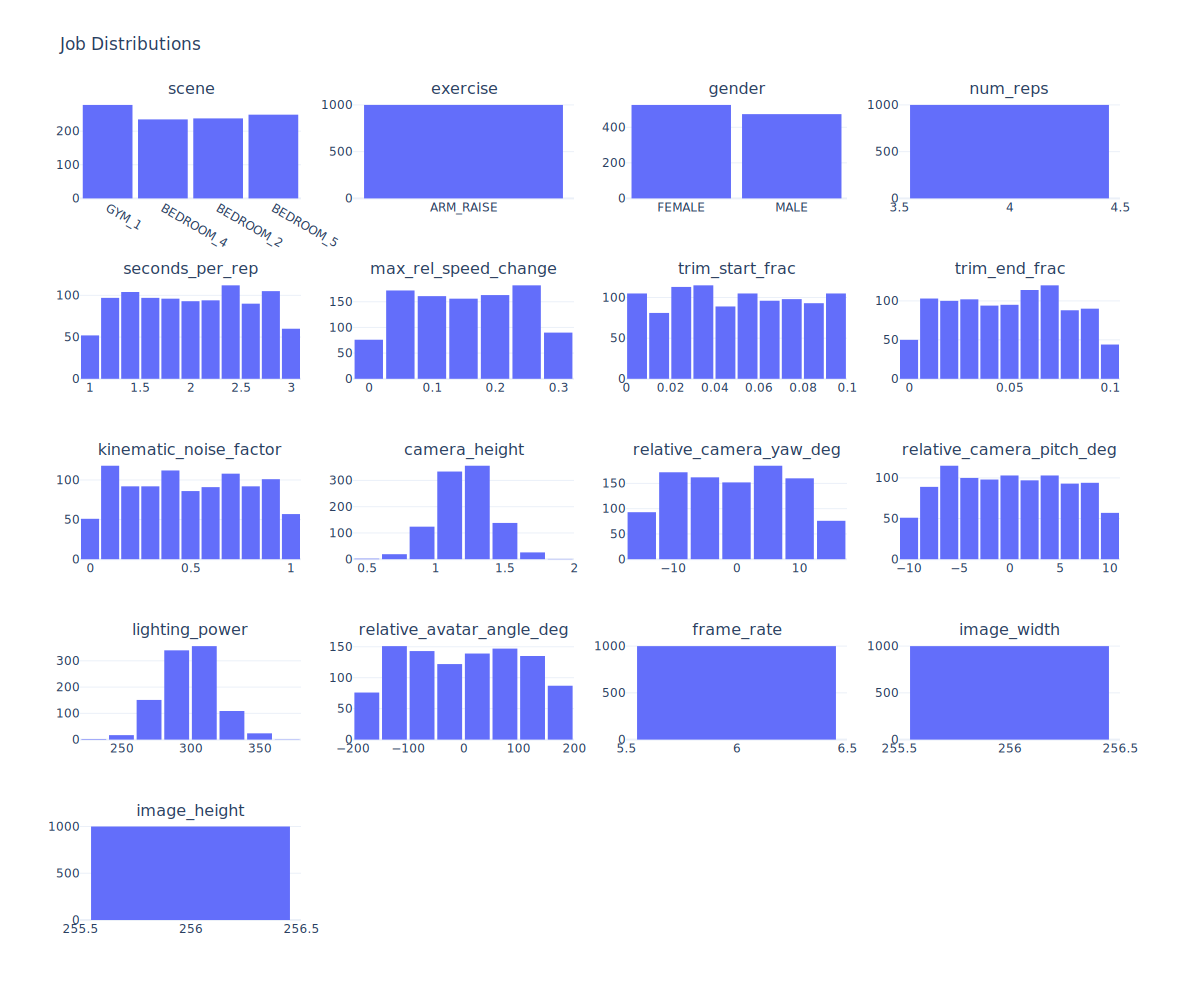

In [4]:
visualize_job_params(job_params)

### Submit many jobs in batch mode.

After verifying our parameters are in the correct range, we can submit a large batch of jobs to the API.

High-resolution videos can take some time to render (~20 minutes per video), so this part is **non-blocking**. That is, you can run this cell and then shut down your notebook if you like. We save your job ids to your local disk, so you can pick right up in the next section when you come back.

**Note** We don't actually want to submit a job for 1000 videos for this demo notebook, so the next cell will just take the first 5. **Delete the next cell when you're ready to generate videos at scale.**

In [5]:
job_params = job_params[:5] #comment out or delete this cell for the full jobs array.

In [6]:
_, batch_folder = api.submit_video_batch_to_api(
    token=TOKEN,
    job_params=job_params,
    output_dir=OUTPUT_DIR,
    batch_folder_suffix=batch_folder_suffix,
)

print(f"Batch folder (use this folder path to poll status after restarting): {batch_folder}")

Submitting jobs to API...


  0%|          | 0/5 [00:00<?, ?it/s]

Batch folder (use this folder path to poll status after restarting): ./tmp/20220504_T101250926399_batch_arm_raises


### Query job status in non-blocking mode.

We next show how to check on the status of a specific batch (potentially after closing and restarting this notebook). You only need to provide a path to the associated folder. Note that you can choose to move onto the next cell and download data before all jobs have successfully completed.

In [7]:
# Reconstitute our batch process state (replace `batch_folder` with desired batch folder)
batch = api.Batch.from_batch_folder(batch_folder_path=batch_folder, token=TOKEN)

# Poll the server to see the status of our batch job.
successful_jobs, failed_jobs = batch.get_completed_jobs_valid_and_invalid()

num_successful = len(successful_jobs)
num_failed = len(failed_jobs)
num_submitted = len(batch.job_ids)

print(f"{num_successful+num_failed}/{num_submitted} submitted jobs have completed.")
print(f"{num_successful}/{num_successful+num_failed} completed jobs have a valid URL.")

Polling jobs:   0%|          | 0/5 [00:00<?, ?it/s]

5/5 submitted jobs have completed.
5/5 completed jobs have a valid URL.


#### Download completed jobs

Using the cell from above, we can download the completed jobs. We will only download the completed jobs that have a valid URL.

In [8]:
job_folders = api.download_completed_videos(completed_jobs=successful_jobs, output_dir=batch_folder)

  0%|          | 0/5 [00:00<?, ?it/s]

### Visualize dataset statistics + filter for specific properties

Finally, we compile some of the metadata and all of the job parameters that were submitted into a dataframe. This allows us to see the distribution of the resulting dataset. In addition, we can query the dataset for specific properties, which allows us to curate a desired training set for a given ML application.

In [9]:
import pandas as pd
pd.options.display.max_columns = None

df = summarize_batch_results_as_dataframe(batch_folder)
df.round(2).query('avg_percent_occlusion < 4')

,job_path,job_id,num_frames,avg_percent_in_fov,avg_percent_occlusion,scene,exercise,gender,num_reps,seconds_per_rep,max_rel_speed_change,trim_start_frac,trim_end_frac,kinematic_noise_factor,camera_height,relative_camera_yaw_deg,relative_camera_pitch_deg,lighting_power,relative_avatar_angle_deg,frame_rate,image_width,image_height
0,./tmp/20220504_T101250926399_batch_arm_raises/...,811fb942-fba2-4844-a161-60a227789455,32.0,100.00,3.17,BEDROOM_2,ARM_RAISE,MALE,4.0,1.37,0.20,0.08,0.06,0.35,1.34,5.46,-1.51,313.22,68.87,6.0,256.0,256.0
1,./tmp/20220504_T101250926399_batch_arm_raises/...,b809c577-b08d-4e6a-9df7-e4e972422ea8,34.0,100.00,0.39,GYM_1,ARM_RAISE,FEMALE,4.0,1.38,0.03,0.09,0.05,0.61,1.52,-2.12,-5.05,291.74,-148.86,6.0,256.0,256.0
2,./tmp/20220504_T101250926399_batch_arm_raises/...,e452a68d-6be0-4efc-a2c8-36f0418a5940,50.0,95.57,2.26,BEDROOM_4,ARM_RAISE,FEMALE,4.0,2.07,0.02,0.03,0.01,0.27,0.97,2.64,9.83,310.60,73.01,6.0,256.0,256.0
3,./tmp/20220504_T101250926399_batch_arm_raises/...,b31f9858-24bd-4a94-8319-ea4641c813d6,47.0,100.00,0.60,BEDROOM_4,ARM_RAISE,MALE,4.0,2.17,0.25,0.08,0.07,0.79,1.02,-9.20,4.04,267.67,161.39,6.0,256.0,256.0
4,./tmp/20220504_T101250926399_batch_arm_raises/...,14ac4d7e-60eb-41e7-9977-64b995b65cf4,28.0,100.00,2.07,BEDROOM_4,ARM_RAISE,MALE,4.0,1.06,0.19,0.00,0.00,0.88,1.04,-7.99,1.03,326.98,-77.77,6.0,256.0,256.0


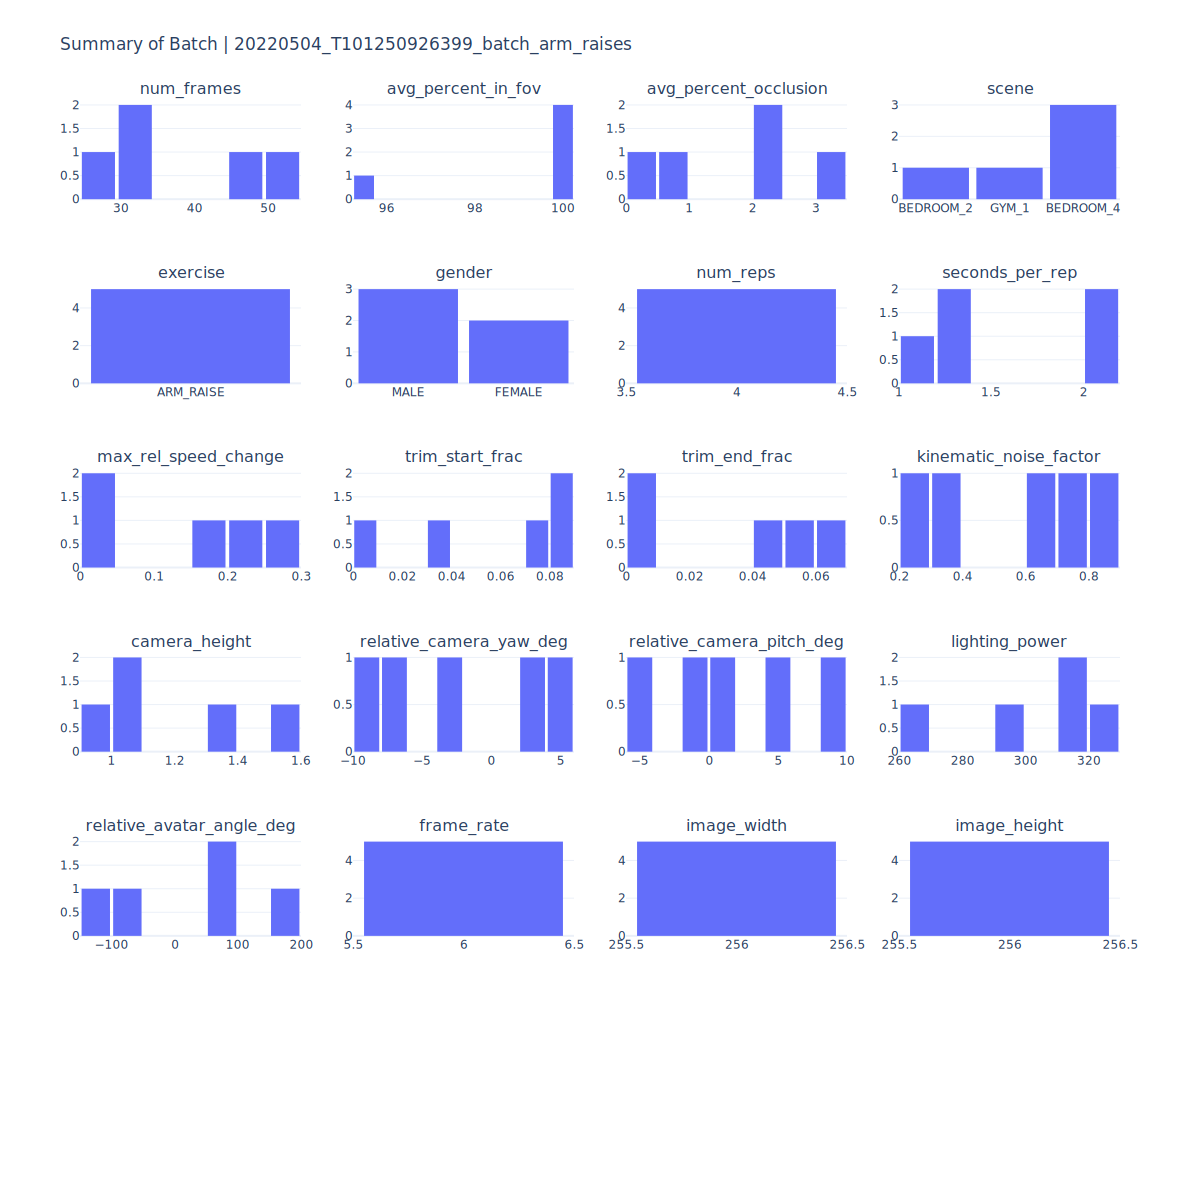

In [10]:
visualize_batch_results(batch_folder)